## Logistic regression

In [1]:
import os, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import utils
#from utils import *

import snowballstemmer
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd 
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from nltk.corpus import stopwords
from nltk import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
import string
import matplotlib.pyplot as plt;
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import pandas as pd
import matplotlib.cm as cm
from sklearn.linear_model import LogisticRegression


import matplotlib.pyplot as plt, seaborn as sns, folium
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from wordcloud import WordCloud, STOPWORDS
from datetime import datetime
import datetime

In [2]:
raw_df= pd.read_csv('/Users/stephenkim/Desktop/yeji/NLP/Tweets.csv')

In [3]:
raw_df.shape

(14640, 15)

In [4]:
#MISSING VARIABLE
raw_df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [5]:
#DATA ONLY WITH TEXT AND SENTIMENT
df = raw_df[['text', 'airline_sentiment']].copy()

In [230]:
#SMAPLE

pd.set_option('display.max_colwidth', -1)
df.sample(5)


,text,airline_sentiment
8912,@Delta was just at T5 a little over a month ago. @Delta you guys are great thanks for everything!,positive
9764,"@USAirways your rude staff said"" I don't care that we are out of market place food you're going on vacation and I have to work"" nice huh",negative
11121,@USAirways but you guys switched me and didn't inform me of the chathes,negative
9464,@USAirways now my rebooked connection is delayed.,negative
8330,@Delta any thoughts on waiver of change fees for travel out of Boston this weekend?,neutral


In [6]:
def clean_text(txt):
    
    """
    removing all hashtags , punctuations, stop_words  and links, also stemming words 
    """
    txt = txt.lower()
    def remove_stopwords(txt):
        return [t for t in txt if t not in stop]
    #txt = re.sub(r"(?<=\w)nt", "not",txt) #change don't to do not cna't to cannot 
    txt = re.sub(r"(@\S+)", "", txt)  # remove hashtags
    txt = re.sub(r'\W', ' ', str(txt)) # remove all special characters including apastrophie 
    txt = txt.translate(str.maketrans('', '', string.punctuation)) # remove punctuations 
    txt = re.sub(r'\s+[a-zA-Z]\s+', ' ', txt)   # remove all single characters (it's -> it s then we need to remove s)
    txt = re.sub(r'\s+', ' ', txt, flags=re.I) # Substituting multiple spaces with single space
    txt = re.sub(r"(http\S+|http)", "", txt) # remove links 
#    txt = ' '.join([PorterStemmer().stem(word=word) for word in txt.split(" ") if word not in stop_words ]) # stem & remove stop words
    txt = ''.join([i for i in txt if not i.isdigit()]).strip() # remove digits ()
    return txt

In [7]:
print('Original Text : ',df['text'][5])  
print('Processed Text : ',clean_text(df['text'][5]))

Original Text :  @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA
Processed Text :  seriously would pay  flight for seats that didn have this playing it really the only bad thing about flying va


In [8]:
#APPLYING IT TO ALL 
df['cleaned_text'] = df['text'].apply(clean_text)  

In [9]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

In [10]:
#df['tokenized'] = df['clean_text'].apply(lambda row: tokenize(row))
df['tokenized'] = df['cleaned_text'].apply(lambda row: tokenize(row))

In [11]:
stop = set(stopwords.words('english'))
stop.update(['amp', 'rt', 'cc'])
stop = stop - set(['no', 'not'])

In [12]:
def remove_stopwords(row):
    return [t for t in row if t not in stop]

In [13]:
df['tokenized'] = df['tokenized'].apply(lambda row: remove_stopwords(row))

In [14]:
pd.set_option('display.max_colwidth', -1)

In [15]:
df[['text', 'tokenized']].head()

,text,tokenized
0,@VirginAmerica What @dhepburn said.,[said]
1,@VirginAmerica plus you've added commercials to the experience... tacky.,"[plus, added, commercials, experience, tacky]"
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,"[today, must, mean, need, take, another, trip]"
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","[really, aggressive, blast, obnoxious, entertainment, guests, faces, little, recourse]"
4,@VirginAmerica and it's a really big bad thing about it,"[really, big, bad, thing]"


In [16]:
le = LabelEncoder()
df['target'] = le.fit_transform(df['airline_sentiment'])

### train, TFIDF 

In [17]:
def train_test_data():   
    y = df['airline_sentiment']   # define target and feature column
    X = df['cleaned_text']
     
    text_train, text_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)    # do the split
    vect = TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8, tokenizer=tokenize) # create Count vectorizer.
    X_train = vect.fit(text_train).transform(text_train) # transform text_train  into a vector 
    X_test = vect.transform(text_test) 
    feature_names = vect.get_feature_names() # to return all words used in vectorizer
  
    return X_train, X_test, y_train, y_test, feature_names

In [244]:
X_train, X_test, y_train, y_test, feature_names = train_test_data()
print(X_train.shape)
print(X_test.shape)

(11712, 2029)
(2928, 2029)


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

lgstc = LogisticRegressionCV(solver="newton-cg", multi_class='auto') 
lgstc.fit(X_train, y_train)

/Users/stephenkim/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='newton-cg', tol=0.0001, verbose=0)

### train  Countvect. 

In [20]:
def train_test_data():   
    y = df['airline_sentiment']   # define target and feature column
    X = df['cleaned_text']
     
    text_train, text_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)    # do the split
    vect = CountVectorizer(min_df =5, ngram_range=(1, 2),tokenizer=tokenize )# create Count vectorizer.
    X_train = vect.fit(text_train).transform(text_train) # transform text_train  into a vector 
    X_test = vect.transform(text_test) 
    feature_names = vect.get_feature_names() # to return all words used in vectorizer
  
    return X_train, X_test, y_train, y_test, feature_names

In [21]:
X_train, X_test, y_train, y_test, feature_names = train_test_data()
print(X_train.shape)
print(X_test.shape)

(11712, 7568)
(2928, 7568)


### Test performance

In [201]:
def print_model_performance(model,X_train,X_test,y_train,y_test):
    training_sample = model.predict(X_train)
    testing_sample = model.predict(X_test)
    print('training ')
    #print(classification_report(training_sample, y_train))  #uncomment if you want to see full report 
    print('train accuracy ',accuracy_score(training_sample, y_train))
    print('train precision_score ',precision_score(training_sample, y_train,average='micro')) 
    print('train recall score',recall_score(training_sample, y_train,average='micro')) 
    
    print('\n testing  ')
    print(classification_report(testing_sample, y_test))   #uncomment if you want to see full report 
    print('test average accuracy ',accuracy_score(testing_sample, y_test))
    print('test average precision_score ',precision_score(testing_sample, y_test,average='micro')) 
    print('test average recall score',recall_score(testing_sample, y_test,average='micro')) 
 #   print('test AUC ',roc_auc_score(testing_sample, y_test,average='micro'))
    
    print(confusion_matrix(testing_sample, y_test))

In [202]:
#TFIDF 
print_model_performance(lgstc, X_train, X_test, y_train, y_test)

training 
train accuracy  0.879183743169399
train precision_score  0.879183743169399
train recall score 0.879183743169399

 testing  
              precision    recall  f1-score   support

    negative       0.91      0.85      0.88      1997
     neutral       0.59      0.66      0.62       551
    positive       0.66      0.77      0.71       380

    accuracy                           0.80      2928
   macro avg       0.72      0.76      0.74      2928
weighted avg       0.82      0.80      0.81      2928

test average accuracy  0.8029371584699454
test average precision_score  0.8029371584699454
test average recall score 0.8029371584699454
[[1694  210   93]
 [ 129  364   58]
 [  47   40  293]]


### Confusion matrix and ROC

In [203]:
y_true=y_test
y_pred=lgstc.predict(X_test)
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_true, y_pred)

array([[[ 755,  303],
        [ 176, 1694]],

       [[2127,  187],
        [ 250,  364]],

       [[2397,   87],
        [ 151,  293]]])

In [204]:
class_names = np.array(['Negative', 'Neutral', 'Positive'])

In [205]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[1694  129   47]
 [ 210  364   40]
 [  93   58  293]]


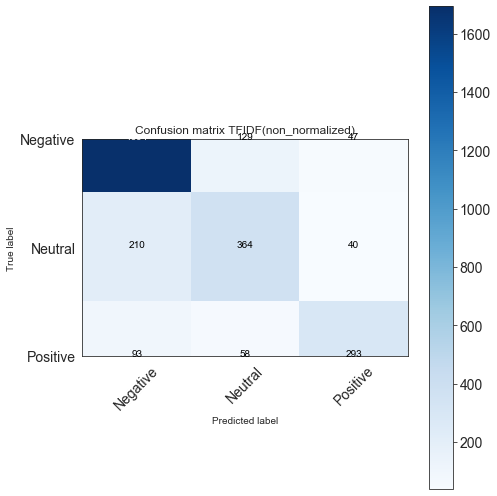

In [228]:
#TFIDF 
cnf_matrix = confusion_matrix(y_test, lgstc.predict(X_test),labels=['negative', 'neutral', 'positive'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#fig, ax = plt.subplots()
#ax.set_ylim(len(harvest)-0.5, -0.5)
plt.figure(figsize=(7,7))
#plt.figure()

plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Neutral', 'Positive'],
                      title='Confusion matrix TFIDF(non_normalized)')

In [209]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

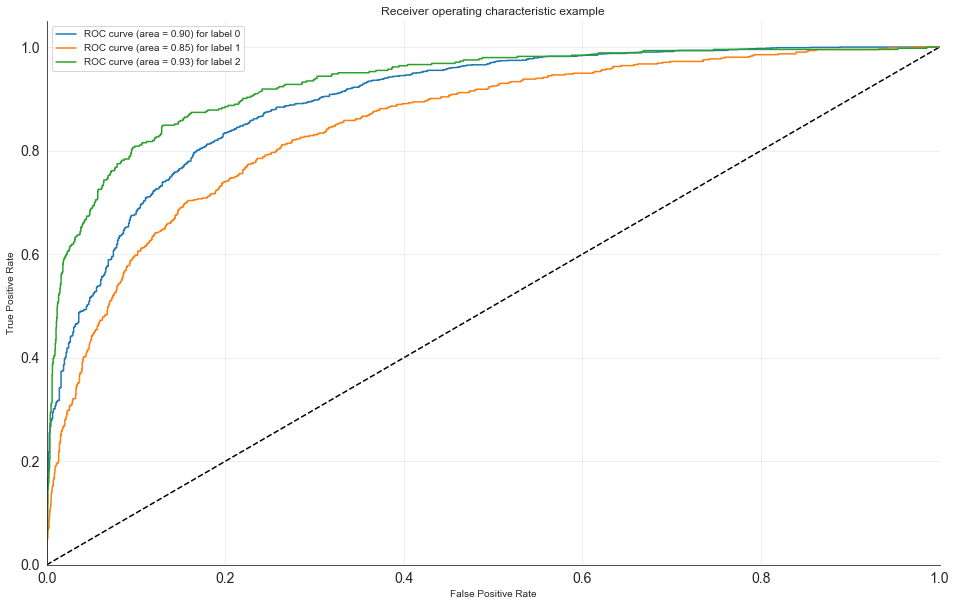

In [211]:
#TFIDF
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(lgstc, X_test, y_test, n_classes=3, figsize=(16, 10))

In [25]:
# countvectorizer

def print_model_performance(model,X_train,X_test,y_train,y_test):
    training_sample = model.predict(X_train)
    testing_sample = model.predict(X_test)
    print('training ')
    #print(classification_report(training_sample, y_train))  #uncomment if you want to see full report 
    print('train accuracy ',accuracy_score(training_sample, y_train))
    print('train precision_score ',precision_score(training_sample, y_train,average='micro')) 
    print('train recall score',recall_score(training_sample, y_train,average='micro')) 
    
    print('\n testing  ')
    print(classification_report(testing_sample, y_test))   #uncomment if you want to see full report 
    print('test average accuracy ',accuracy_score(testing_sample, y_test))
    print('test average precision_score ',precision_score(testing_sample, y_test,average='micro')) 
    print('test average recall score',recall_score(testing_sample, y_test,average='micro')) 
 #   print('test AUC ',roc_auc_score(testing_sample, y_test,average='micro'))
    
    print(confusion_matrix(testing_sample, y_test))

In [26]:
#countvect 
print_model_performance(lgstc, X_train, X_test, y_train, y_test)

training 
train accuracy  0.9348531420765027
train precision_score  0.9348531420765027
train recall score 0.9348531420765027

 testing  
              precision    recall  f1-score   support

    negative       0.89      0.85      0.87      1952
     neutral       0.62      0.63      0.62       607
    positive       0.65      0.78      0.71       369

    accuracy                           0.80      2928
   macro avg       0.72      0.75      0.73      2928
weighted avg       0.80      0.80      0.80      2928

test average accuracy  0.7974726775956285
test average precision_score  0.7974726775956285
test average recall score 0.7974726775956285
[[1667  195   90]
 [ 159  381   67]
 [  44   38  287]]


In [27]:
y_true=y_test
y_pred=lgstc.predict(X_test)
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_true, y_pred)

array([[[ 773,  285],
        [ 203, 1667]],

       [[2088,  226],
        [ 233,  381]],

       [[2402,   82],
        [ 157,  287]]])

In [28]:
class_names = np.array(['Negative', 'Neutral', 'Positive'])

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[1667  159   44]
 [ 195  381   38]
 [  90   67  287]]


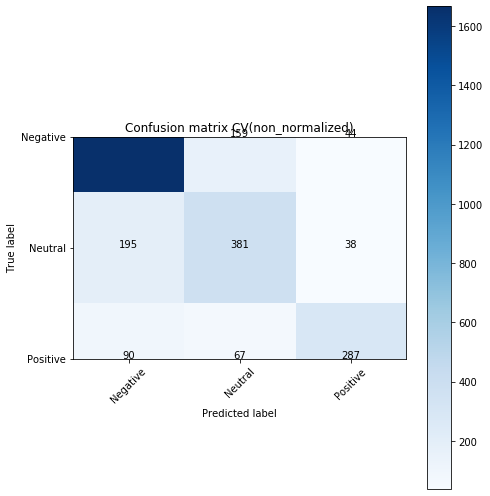

In [30]:
cnf_matrix = confusion_matrix(y_test, lgstc.predict(X_test),labels=['negative', 'neutral', 'positive'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#fig, ax = plt.subplots()
#ax.set_ylim(len(harvest)-0.5, -0.5)
plt.figure(figsize=(7,7))
#plt.figure()

plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Neutral', 'Positive'],
                      title='Confusion matrix CV(non_normalized)')

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

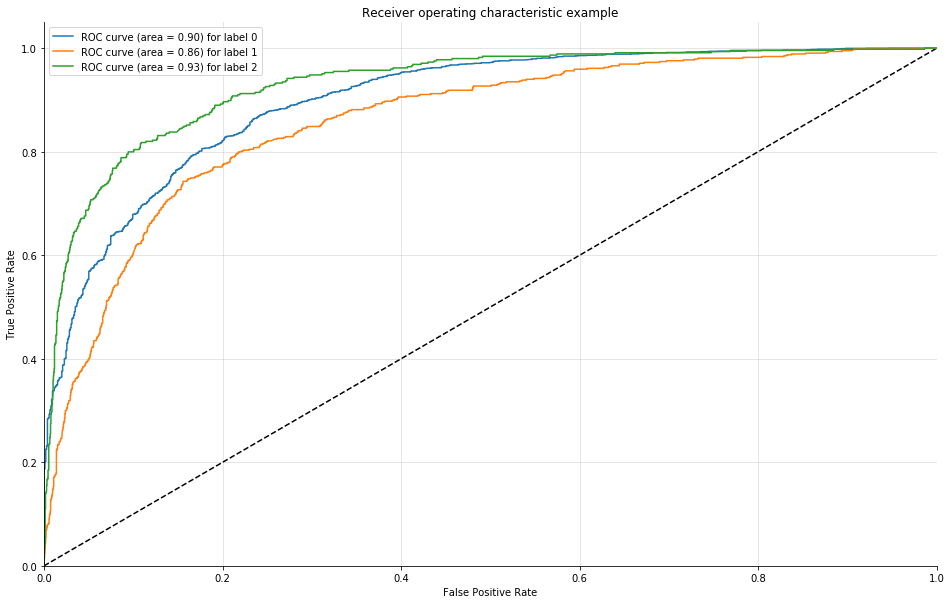

In [33]:
#CV
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(lgstc, X_test, y_test, n_classes=3, figsize=(16, 10))

### Tokens importance

In [140]:

def get_tokens_coefs(vocab, coefs, n):
    coef_df = pd.DataFrame({'vocab': vocab, 'coef':coefs.reshape(-1)})
    return coef_df.sort_values('coef', ascending=False).reset_index(drop=True)[:n]

In [141]:
def plot_tokens_coefs(df, ax, label):
    df.sort_values('coef').plot.barh(legend=False, ax=ax)
    ax.set_yticklabels(df['vocab'].values.tolist()[::-1])
    ax.set_title(label);


In [142]:
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
sns.set_style(style='white')

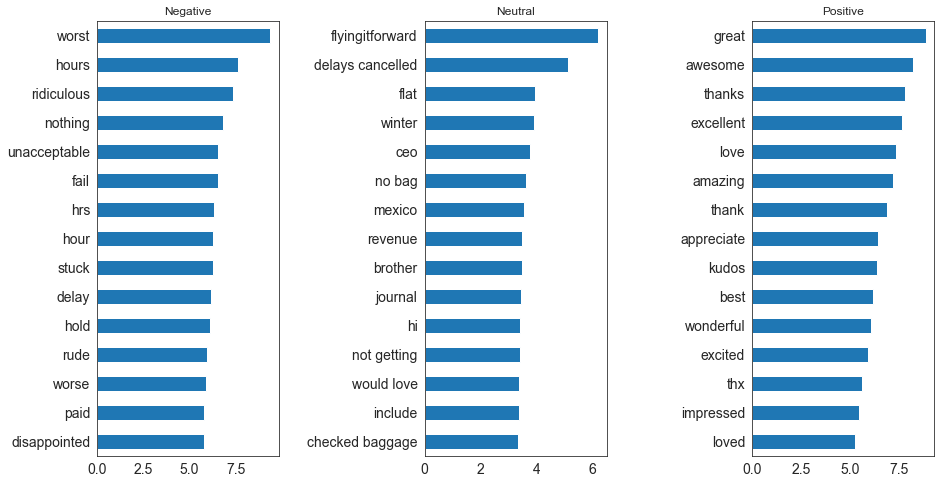

In [143]:
vocab = vect.get_feature_names()
n_coefs = 15

fig, axs = plt.subplots(1, 3, figsize=(15, 8))
fig.subplots_adjust(wspace=0.8)

for i, l in enumerate(['Negative', 'Neutral', 'Positive']):
    coef_df = get_tokens_coefs(vocab, m.coef_[i], n_coefs)
    plot_tokens_coefs(coef_df, axs[i], l)

    
fig.savefig('tokenabcdef.png', transparent=True)